# Demos for deep learning.
20210128, Qin ZhaoYu.

<AxesSubplot:>

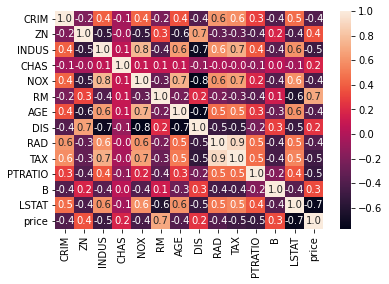

In [2]:
import numpy as np, pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston

data = load_boston()
dataframe = pd.DataFrame(data["data"])
dataframe.columns = data["feature_names"]
dataframe["price"] = pd.Series(data["target"])

sns.heatmap(dataframe.corr(), annot=True, fmt=".1f")

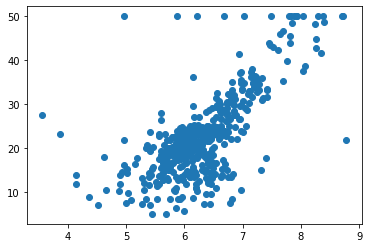

In [3]:
plt.scatter(dataframe["RM"], dataframe["price"])

In [15]:
x = dataframe["RM"]
y = dataframe["price"]
history_notes = {_x : _y for _x, _y in zip(x, y)}
print("6.88 in notes" if 6.88 in history_notes else "6.88 not in notes")

# 把字典的键值对列表按照与目标x的距离排序后切片前三组数据。
similary_xy = np.array(sorted(history_notes.items(), key=lambda xy: (xy[0] - 6.88)**2)[:3])  
print(similary_xy)
np.mean(similary_xy[:, 1])

6.88 not in notes
[[ 6.879 27.5  ]
 [ 6.874 31.2  ]
 [ 6.871 24.8  ]]


27.833333333333332

# 用历史数据来预测未曾见到的过的数据，最直接的方法：
**K-Neighbor-Nearst**

In [18]:
def knn(query_x, history, top_n=3):
    sorted_notes = sorted(history.items(), key=lambda xy: (xy[0] - query_x)**2)
    similary_notes = sorted_notes[:top_n]
    similary_ys = [y for _, y in similary_notes]
    return np.mean(similary_ys)

knn(6.88, history_notes)

27.833333333333332

# 为了更快的获得结果，希望通过拟合函数来获得预测能力
$$ f(rm) = k*rm + b$$   
## Random Approach 
$$ loss(y, \hat{y}) = \frac{1}{N} {\sum_{i \in N}(y_i - \hat{y_i})^2} $$  
$$ loss(y, \hat{y}) = \frac{1}{N} {\sum_{i \in N}(k*rm_i + b - \hat{y_i})^2} $$  

step:0，f(rm) = -88 * rm + -71, loss: 422755.6490560632
step:1，f(rm) = 6 * rm + -7, loss: 115.17242231620553
step:99，f(rm) = 10 * rm + -38, loss: 49.35022272727272
step:140，f(rm) = 7 * rm + -23, loss: 48.150430243082994
step:343，f(rm) = 7 * rm + -22, loss: 46.069699017786554
step:861，f(rm) = 11 * rm + -46, loss: 45.73304483596838


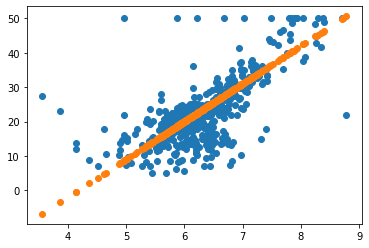

In [26]:
import random
min_loss = float('inf')
best_k, best_b = None, None

def loss(y_hat, y):
    return np.mean((y_hat - y)**2)

for step in range(1000):
    min_v, max_v = -100, 100
    k, b = random.randrange(min_v, max_v), random.randrange(min_v, max_v)
    y_hats = [k*rm_i+b for rm_i in x]
    curr_loss = loss(y_hats, y)

    if curr_loss < min_loss:
        min_loss = curr_loss
        best_k, best_b = k, b
        print('step:{}，f(rm) = {} * rm + {}, loss: {}'.format(step, k, b, curr_loss))

plt.scatter(x, y)
plt.scatter(x, [best_k*_x + best_b for _x in x])

# 蒙特卡洛模拟
我们可以通过监督的方法，来获得更快的函数权值更新

## Supervisor   
$$ Loss(k, b) = \frac{1}{N} {\sum_{i \in N}(k*rm_i + b - \hat{y_i})^2} $$    
$$ \frac{\partial{Loss(k, b)}}{\partial{k}} = \frac{2}{N} {\sum_{i \in N}(k*rm_i+b - \hat{y_i})*rm_i} $$ $$ \frac{\partial{Loss(k, b)}}{\partial{b}} = \frac{2}{N} {\sum_{i \in N}(k*rm_i+b - \hat{y_i})} $$   

therefore  
$$ k_{n+1} = k_{n} + -1*\frac{\partial{Loss(k, b)}}{\partial{k}}*dk $$
$$ b_{n+1} = b_{n} + -1*\frac{\partial{Loss(k, b)}}{\partial{b}}*db $$

step:0，f(rm) = 2.9954617828298584 * rm + 0.5403642731626364, loss: 72.00398662158257
step:1，f(rm) = 3.45371237423031 * rm + 0.5461067231593938, loss: 59.39886398701148
step:2，f(rm) = 3.544738548714192 * rm + 0.5402929996300063, loss: 58.89828352793541
step:3，f(rm) = 3.5636939609658156 * rm + 0.532212993857947, loss: 58.87025787012995
step:4，f(rm) = 3.5685046881912506 * rm + 0.5236899149663461, loss: 58.86167739277639
step:5，f(rm) = 3.5705391494589653 * rm + 0.5150815807477209, loss: 58.85409276824764
step:6，f(rm) = 3.5720284807512765 * rm + 0.5064582151603918, loss: 58.84659777713533
step:7，f(rm) = 3.5734105589920167 * rm + 0.497833599756054, loss: 58.8391191332316
step:8，f(rm) = 3.5747713208159144 * rm + 0.48921043884877374, loss: 58.831646481600515
step:9，f(rm) = 3.576127631985573 * rm + 0.4805892627633034, loss: 58.82417794413036


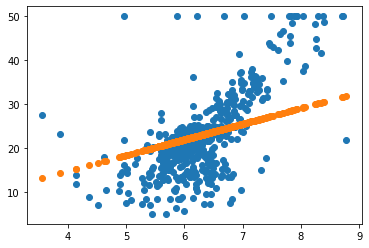

In [31]:
def partial_k(k, b, x, y):
    return 2*np.mean((k*x + b - y)*x)

def partial_b(k, b, x, y):
    return 2*np.mean(k*x + b - y)

k, b = random.random(), random.random()
min_loss = float('inf')
best_k, best_b = None, None
learn_rate = 1e-2

for step in range(10):
    k = k + partial_k(k, b, x, y)*(-1)*learn_rate
    b = b + partial_b(k, b, x, y)*(-1)*learn_rate
    y_hat = k*x + b 
    curr_loss = loss(y_hat, y)

    if curr_loss < min_loss:
        best_k, best_b = k, b
        min_loss = curr_loss
        print('step:{}，f(rm) = {} * rm + {}, loss: {}'.format(step, k, b, curr_loss))

plt.scatter(x, y)
plt.scatter(x, best_k*x+b)